**NOTE:** You probably will see warnings. These are not errors! However, you should read them and try to understand why they're there. Can you fix them?

![](http://rentinginla.com/wp-content/uploads/2015/12/Buying.jpg)
# [Project 2: Predicting House Prices with Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

The goal of this project is for you to use EDA, visualization, data cleaning, preprocesing, and linear models to predict home prices given the features of the home, and interpret your linear models to find out what features add value to a home! This project is a bit more open-ended than project 1. 

Be sure to ...

* Think about your choices when it comes to your choices about the data. Be ready to defend your decisions!
* Use lots of plots to dig deeper into the data! Describe the plots and convey what you learned from them.
* Don't forget to read the [description of the data](../data_description.txt) (also available at the kaggle website)! This has valuable information that will help you clean and impute data. `NaN` means something in many of the columns! Don't just drop or fill them!
* Try fitting many models! Document your work and note what you've tried.
* Apply what you've learned in class, books, videos, Kaggle forums, and blog posts. There have been a TON of blog posts about this;  you should seek them out and read them!


From the Kaggle competition website:

    Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

    With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from IPython.display import display

%matplotlib inline 
np.random.seed(42)
import warnings
warnings.filterwarnings('ignore')

## Load the Data 

* The data comes in three separate CSVs located in `../data/`. 
* Load the CSV into a `DataFrame`. 
* Make sure to check the `.head` or `.sample`. How many rows? How many columns?
* Familiarize yourself with the column names and what they represent.
* Is there a column that can be set as the `index`? If so, set that column as the index when loading the data. (`df.set_index()`)

In [2]:
train = pd.read_csv('../data/train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df_train = train.set_index('Id')

In [6]:
df_train.shape

(1460, 80)

**Bonus:** Write an assertion statement to programmatically verify the correct number of rows and columns were imported.

In [8]:
assert len(df_train.columns) == 80 #79 features, plus one ID
assert len(df_train) == 1460 #looking at the csv directly shows 1461 rows, minus one for the headers

## 1. Exploratory Data Analysis (EDA)

### A. Data Types

Read the data description on Kaggle. Which variables are numerical and categorical? Are there any columns that can be deleted? 

Make sure the `dtype` of each column is correct. 

**NOTE:** There is one column in particular that should be categorical but will load in pandas as numeric.

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

### Change MSSubClass to correct datatype

In [9]:
df_train['MSSubClass'] = df_train['MSSubClass'].astype('object')

According to the data description, MSSubClass should be categorical because the different numerical values represent different type of dwelling involved in the sale so the datatype shouldn't be int, but should be treated as str values instead





### Removed unrelated rows and redundant columns

In [10]:
df_train['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

Remove C(commercial) from MSzoning dataset since we are only trying to determine prices of homes so we only want to look at data of Residential properties. 

In [11]:
df_train = df_train[df_train.MSZoning != 'C (all)']
df_train.shape

(1450, 80)

In [12]:
df_train['Street'].value_counts()

Pave    1446
Grvl       4
Name: Street, dtype: int64

I removed GarageCars column since the number of cars that fit into the garage would indicate the size of the Garage Area (both Garaage Cars and Garage Areas measure the size of the garage so we'd only need one of these). I'm choosing to keep Garage Area.

I remove Street column since over 99% of the data are in one category (paved) and the less than 1% (4 out of 1450 data points) are extremely rare cases. Almost every home has the same category of paved street and they are varied in price; therefore, I don't believe that this feature affects homeprice. 


In [12]:
df_train = df_train.drop(['GarageCars', 'Street'], 1)

In [13]:
dtype = df_train.columns.to_series().groupby(df_train.dtypes).groups

In [14]:
cat_col = ['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour',
        'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
        'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
        'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
        'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
        'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
        'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
        'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
        'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
df_cat = pd.DataFrame(df_train[cat_col])

In [15]:
num_col = [col for col in df_train.columns if col not in cat_col]


In [16]:
df_num = pd.DataFrame(df_train[num_col])
print(df_cat.shape)
print(df_num.shape)
print(df_train.shape)

(1460, 43)
(1460, 35)
(1460, 78)




### B. Plot histograms of the numeric columns. 

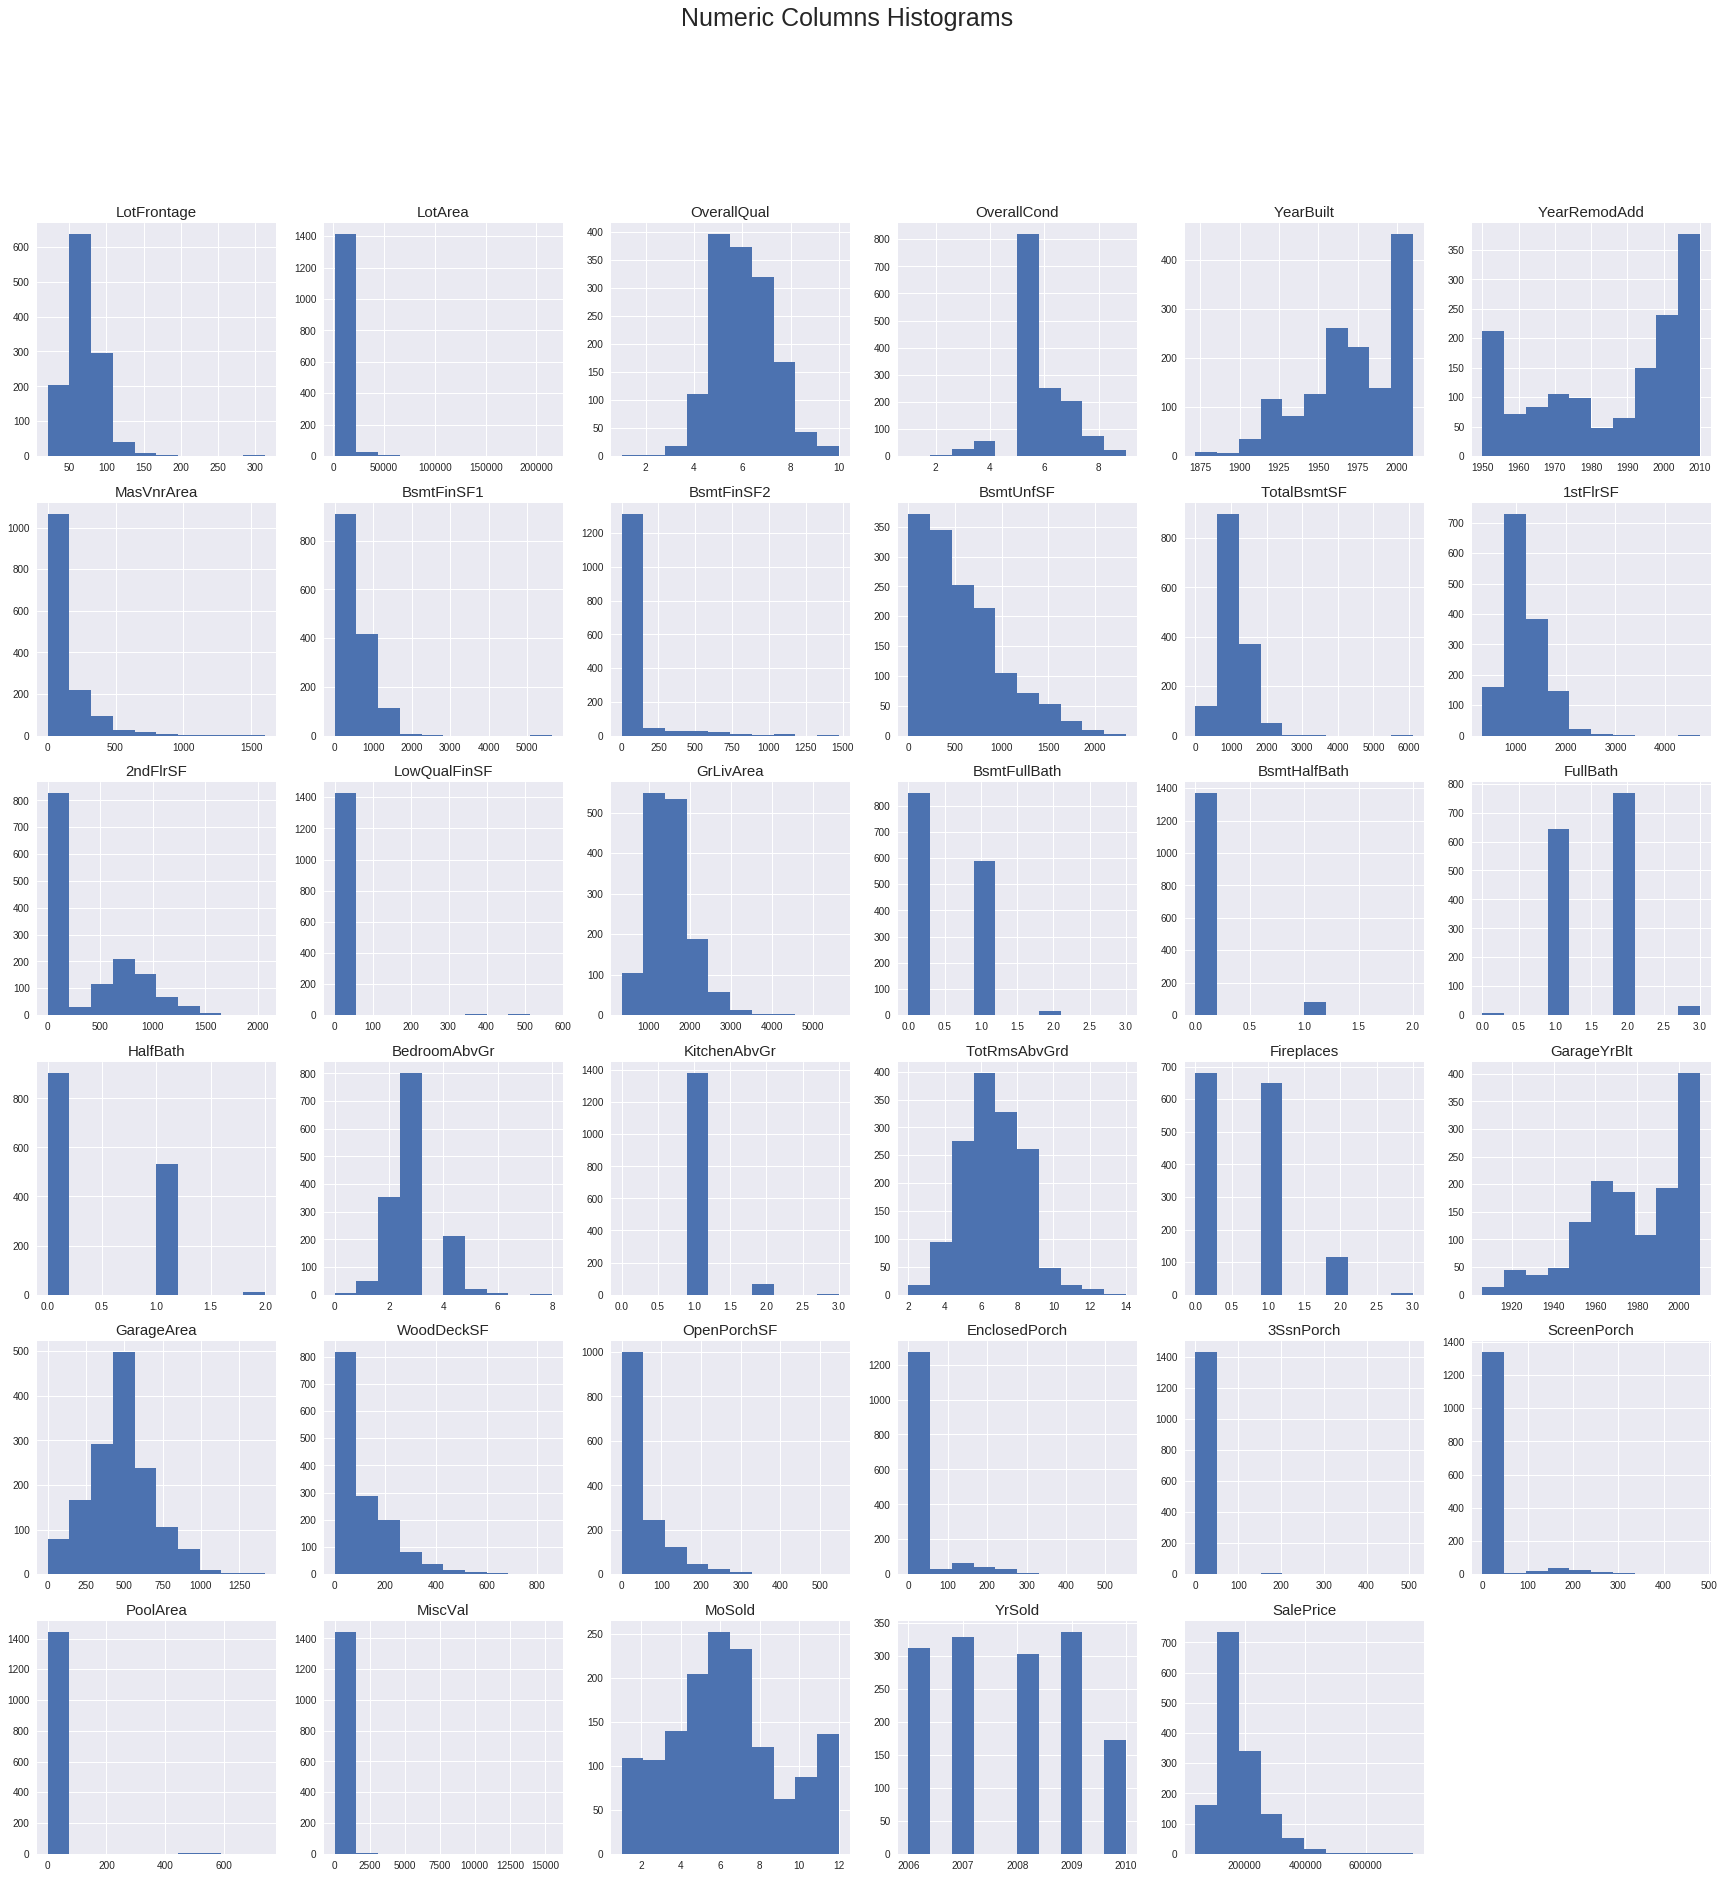

In [18]:
fig1 = plt.figure(1, figsize=(30,30))
fig1.suptitle("Numeric Columns Histograms", fontsize=25)
for i, col in enumerate(df_num.columns):
    fig1.add_subplot(6,6,1+i)
    plt.hist(df_num[col].dropna())
    plt.title(col, fontsize=15)


### What are your observations? Add them to this markdown cell.

-  Most houses were sold in the summer
-  Houses started having garages built in the 1980s
-  Most houses have an overal quality of 5
-  Street have very little differentiation, will most likely exclude from analysis
-  Utilities are almost All Public, will most likely exclude from analysis
-  Condition 2, very little differentiation. Likely exclude
-  PoolQC, Alley, Misc Features almost all Nans. 

### C. Plot the Numeric Columns Against `SalePrice` using scatter plots.

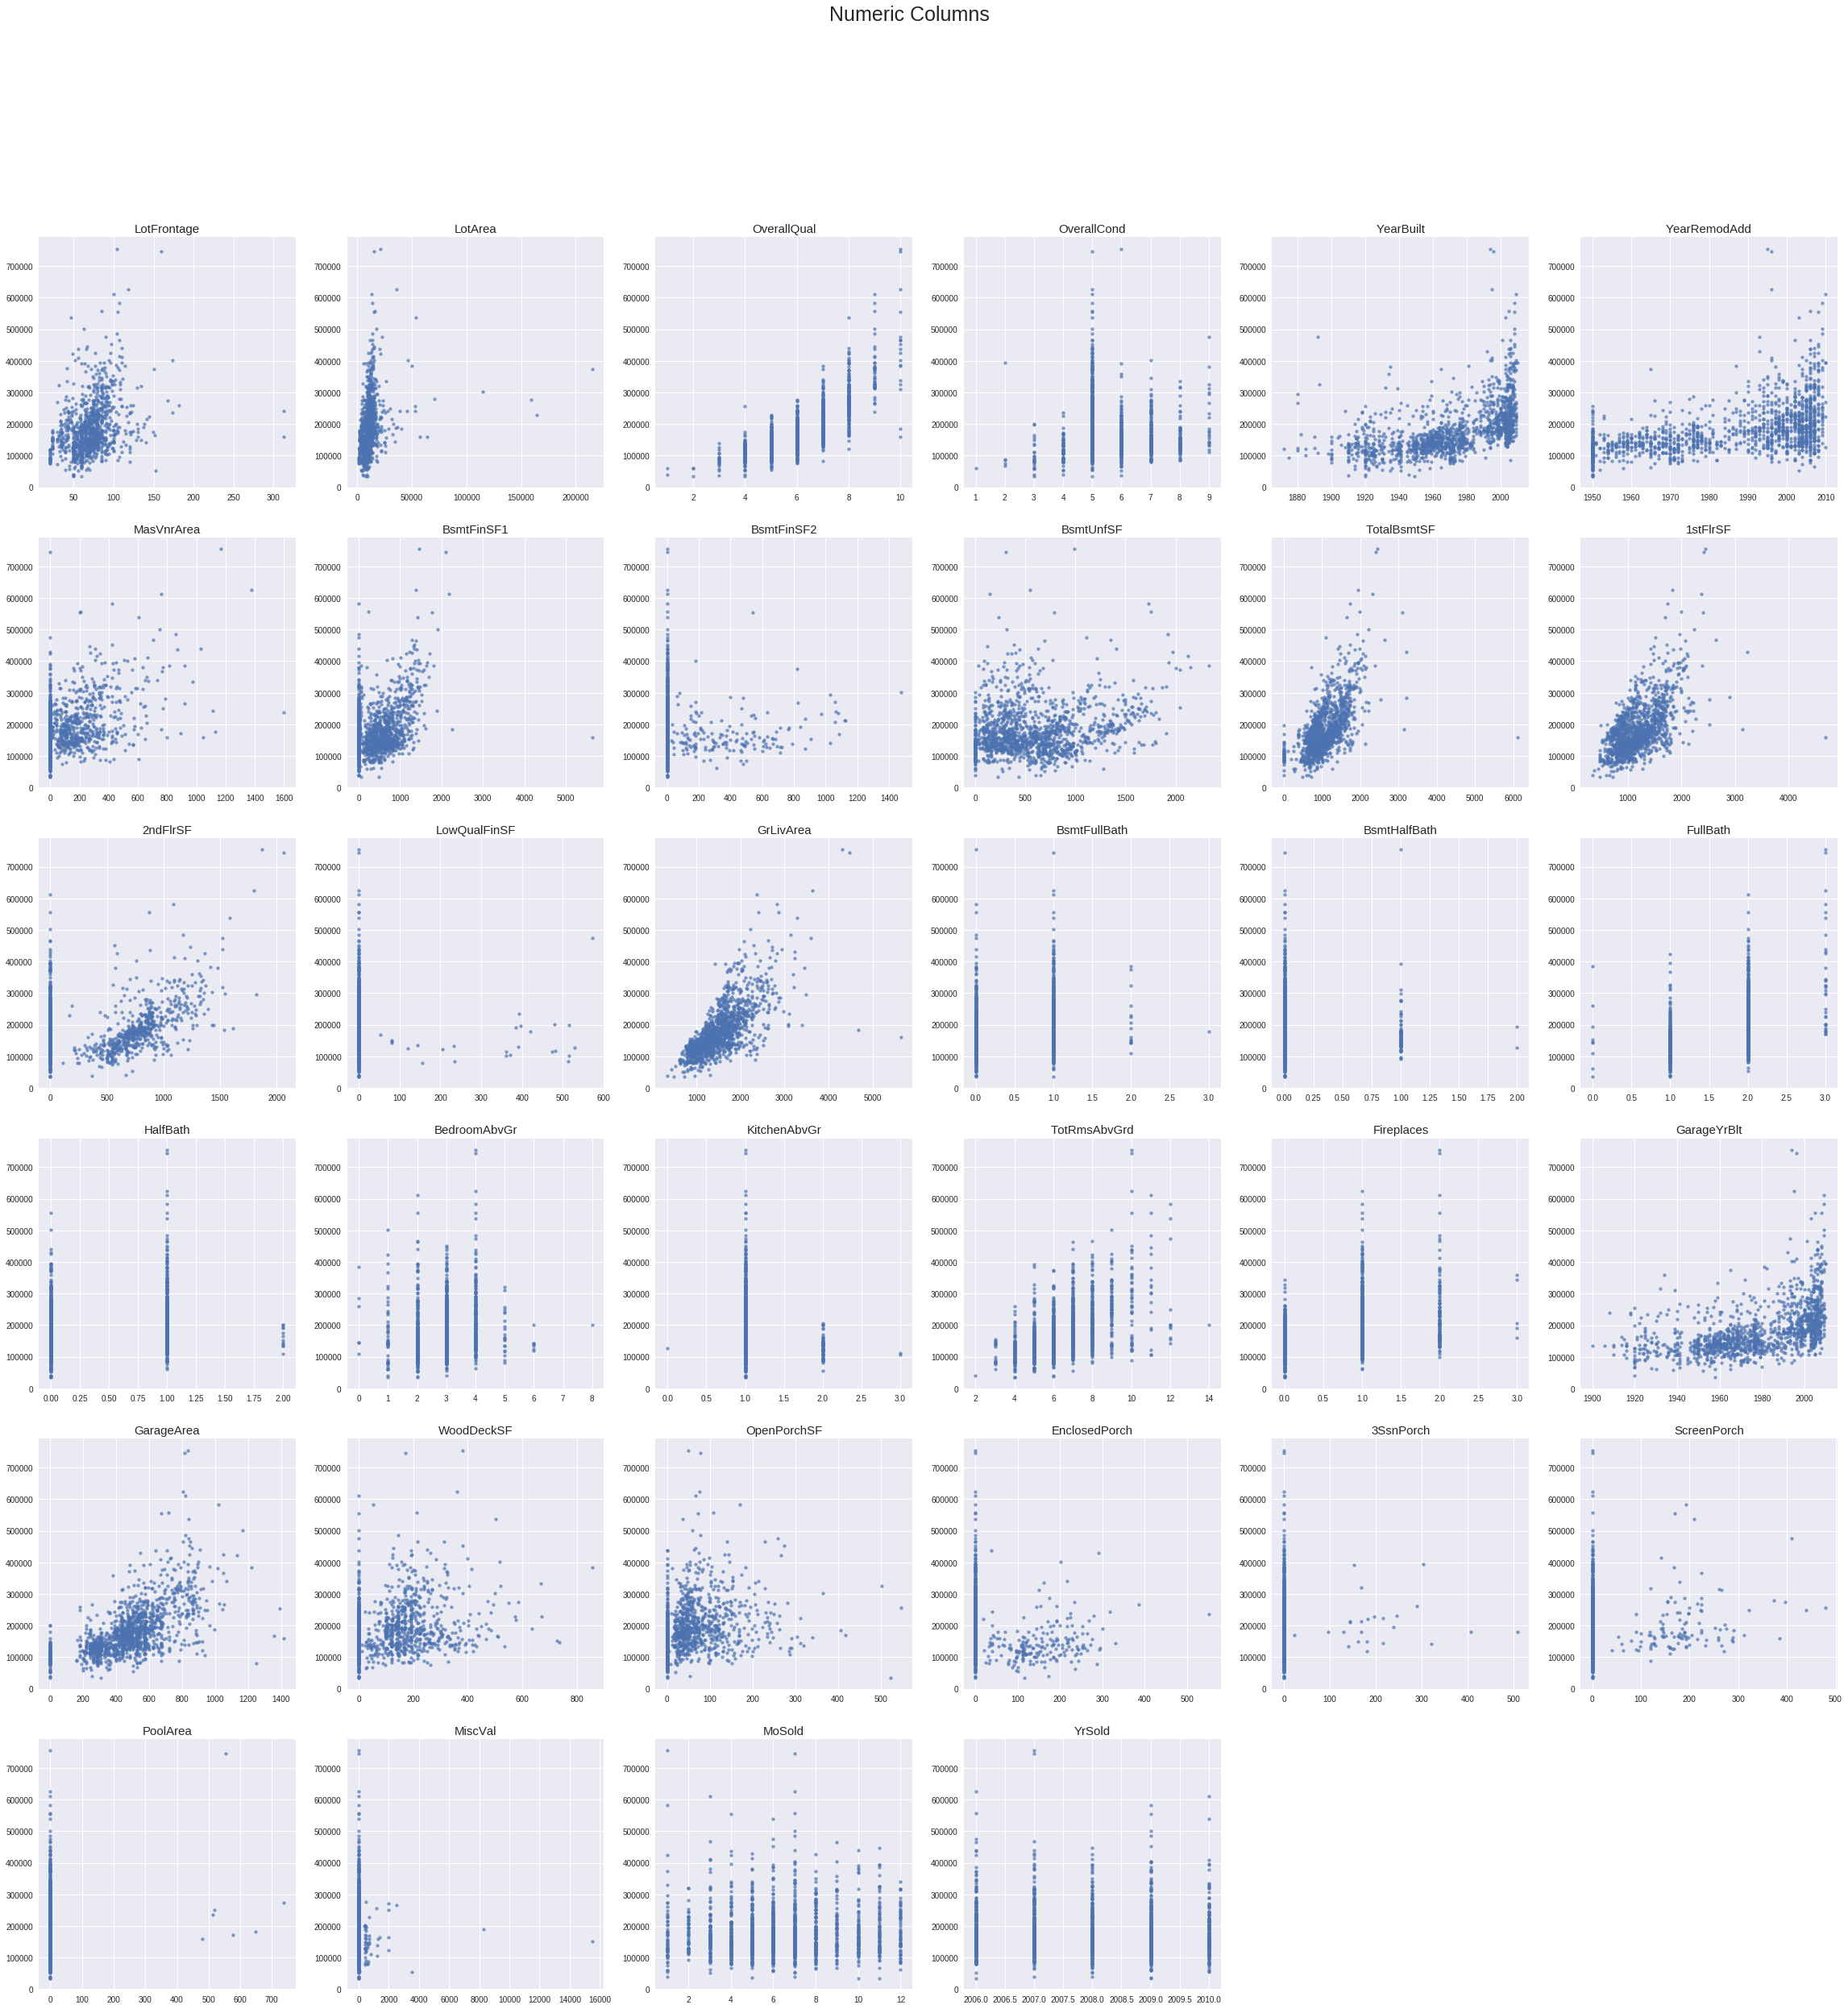

In [17]:
fig = plt.figure(figsize=(40,40))
fig.suptitle("Numeric Columns", fontsize=25)
for i, col in enumerate(df_num.columns):
    if 'SalePrice' not in col:
        fig.add_subplot(6,6,1+i)
        plt.scatter(x=col, y="SalePrice", data=df_train, s=15, alpha =0.7)
        plt.title(col, fontsize=15)

### What are your observations? Add them to this markdown cell.

-  Lotarea does not seem to have a linear relationship with saleprice.
-  OverallQual has a positive linear relationship with Saleprice,  higher Overallqual = higher Saleprice average.
-  YearBulit could also affect saleprice but the relationship is not clear
-  YearRemodAdd also has a flat linear relationship
-  BsmtFinSF1 cluster and could have a positive linear relationship with SalePrice --
-  TotalRmsAbovGrd could affect
-  Garage Area also affect SalePrice
-  Yr Sold does not seem to affect average price, after using box plot, can see that mean sale price does not vary much from year to year so I'm also goint to remove this column from the dataset.



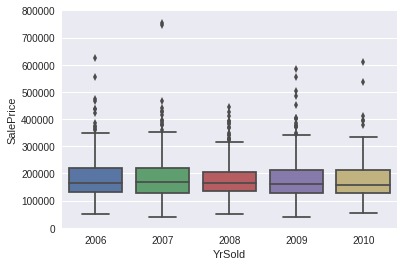

In [19]:
var = 'YrSold'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(6, 4))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

In [20]:
df_train = df_train.drop(['YrSold'], 1)

### D. Use bar plots to plot categorical features against `SalePrice`. 

**HINT:** Look up how to create bar plots in `matplotlib`. You will have to transform the data before you can create a bar plot! Also, look up [how to plot error bars](https://pandas.pydata.org/pandas-docs/stable/visualization.html#plotting-with-error-bars) so you can also observe the variability in your data!

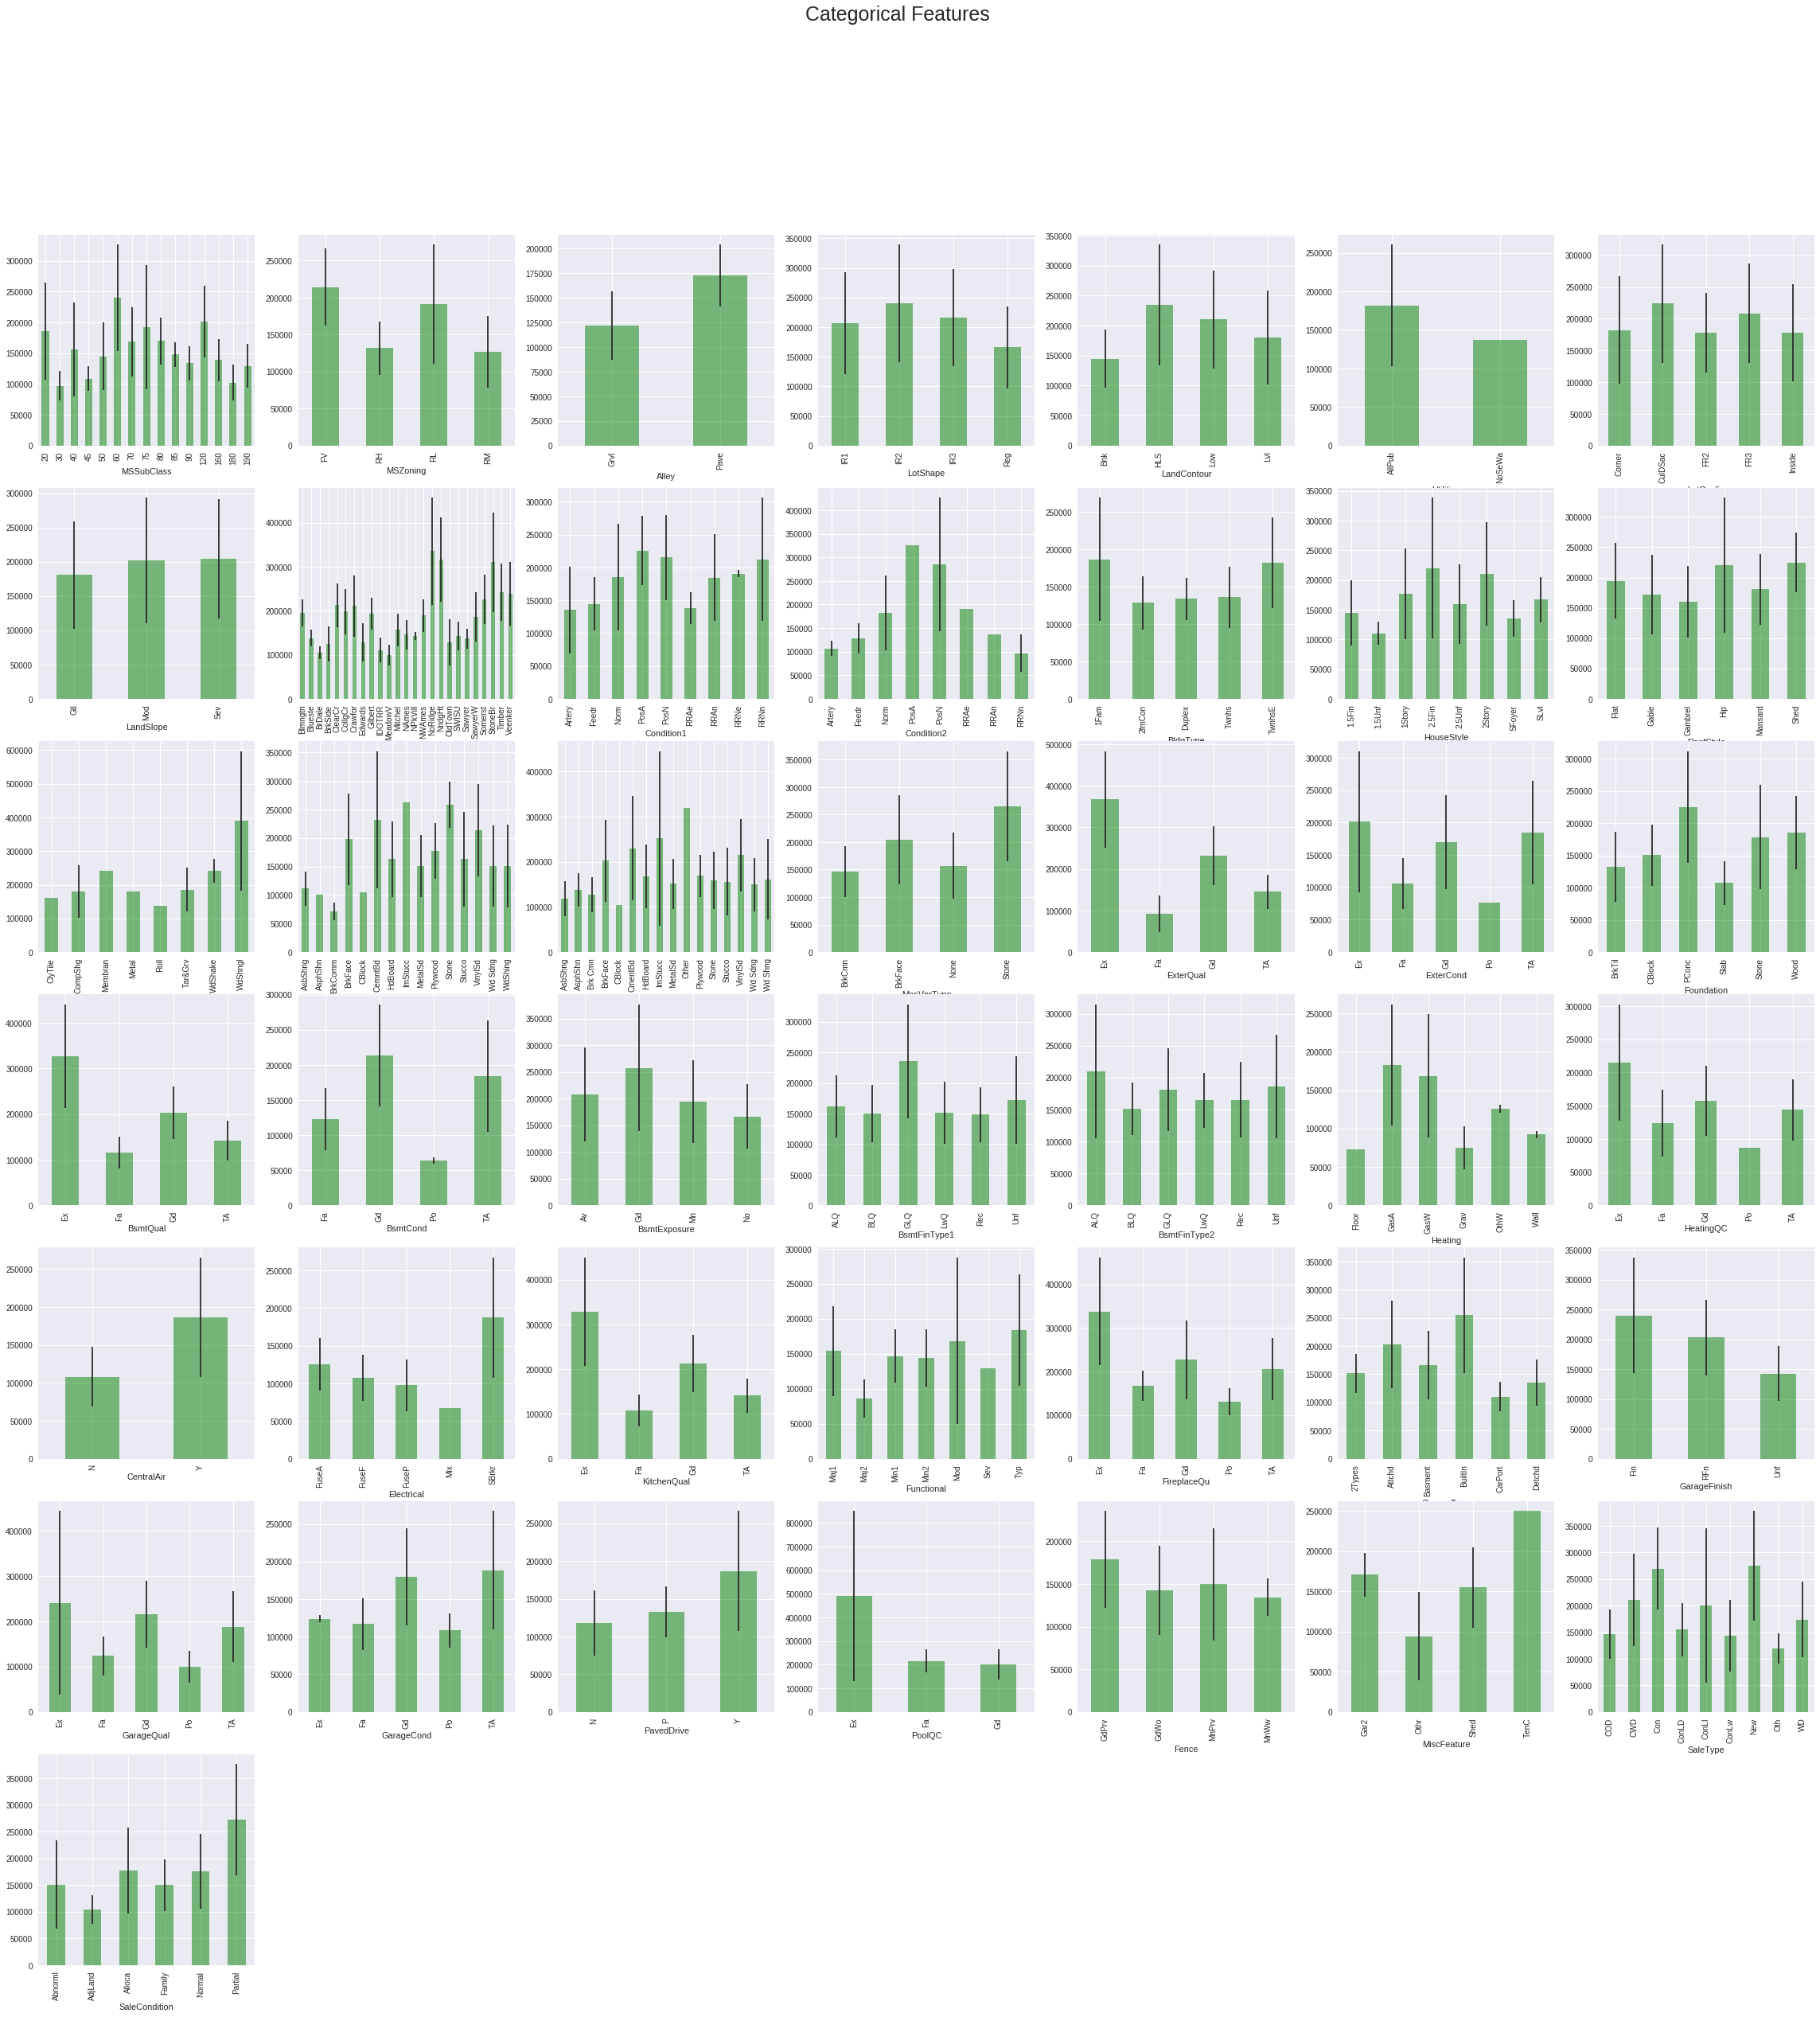

In [21]:
df_train.head()
fig = plt.figure(figsize=(40,40))
for i, col in enumerate(df_cat):
    fig.add_subplot(7,7,i+1)
    fig.suptitle("Categorical Features", fontsize=25)
    errors= df_train.groupby(df_cat.loc[:, col]).SalePrice.std()
    df_train.groupby(df_cat.loc[:, col]).SalePrice.mean().plot.bar(alpha = 0.5, color='g',yerr=errors)

#### What are your observations? Add them to this markdown cell.

---
The mean of saleprice within each categorical column all vary from each other which means that the values could all affect sale price in different ways.

Neighborhood, mssubclass, condition 2, RoofMatl, Exterior1st and 2nd, exter qual, MasVnrTrype, foundation, basment quality, heating, central air, electrical, kitch qual, and sale condition. of the house has the most variability in the mean of sale prices which could indicate that they're important features that affect sale prices